### Simulation Data Exploration

Bacteroides vulgatus ATCC 8482_0.3.pkl
Bacteroides clarus YIT 12056_0.3.pkl
Bacteroides vulgatus ATCC 8482_0.3.pkl
1504
Bacteroides clarus YIT 12056_0.3.pkl
2979


<AxesSubplot:title={'center':'New heatmap:Bacteroides clarus YIT 12056_0.3'}>

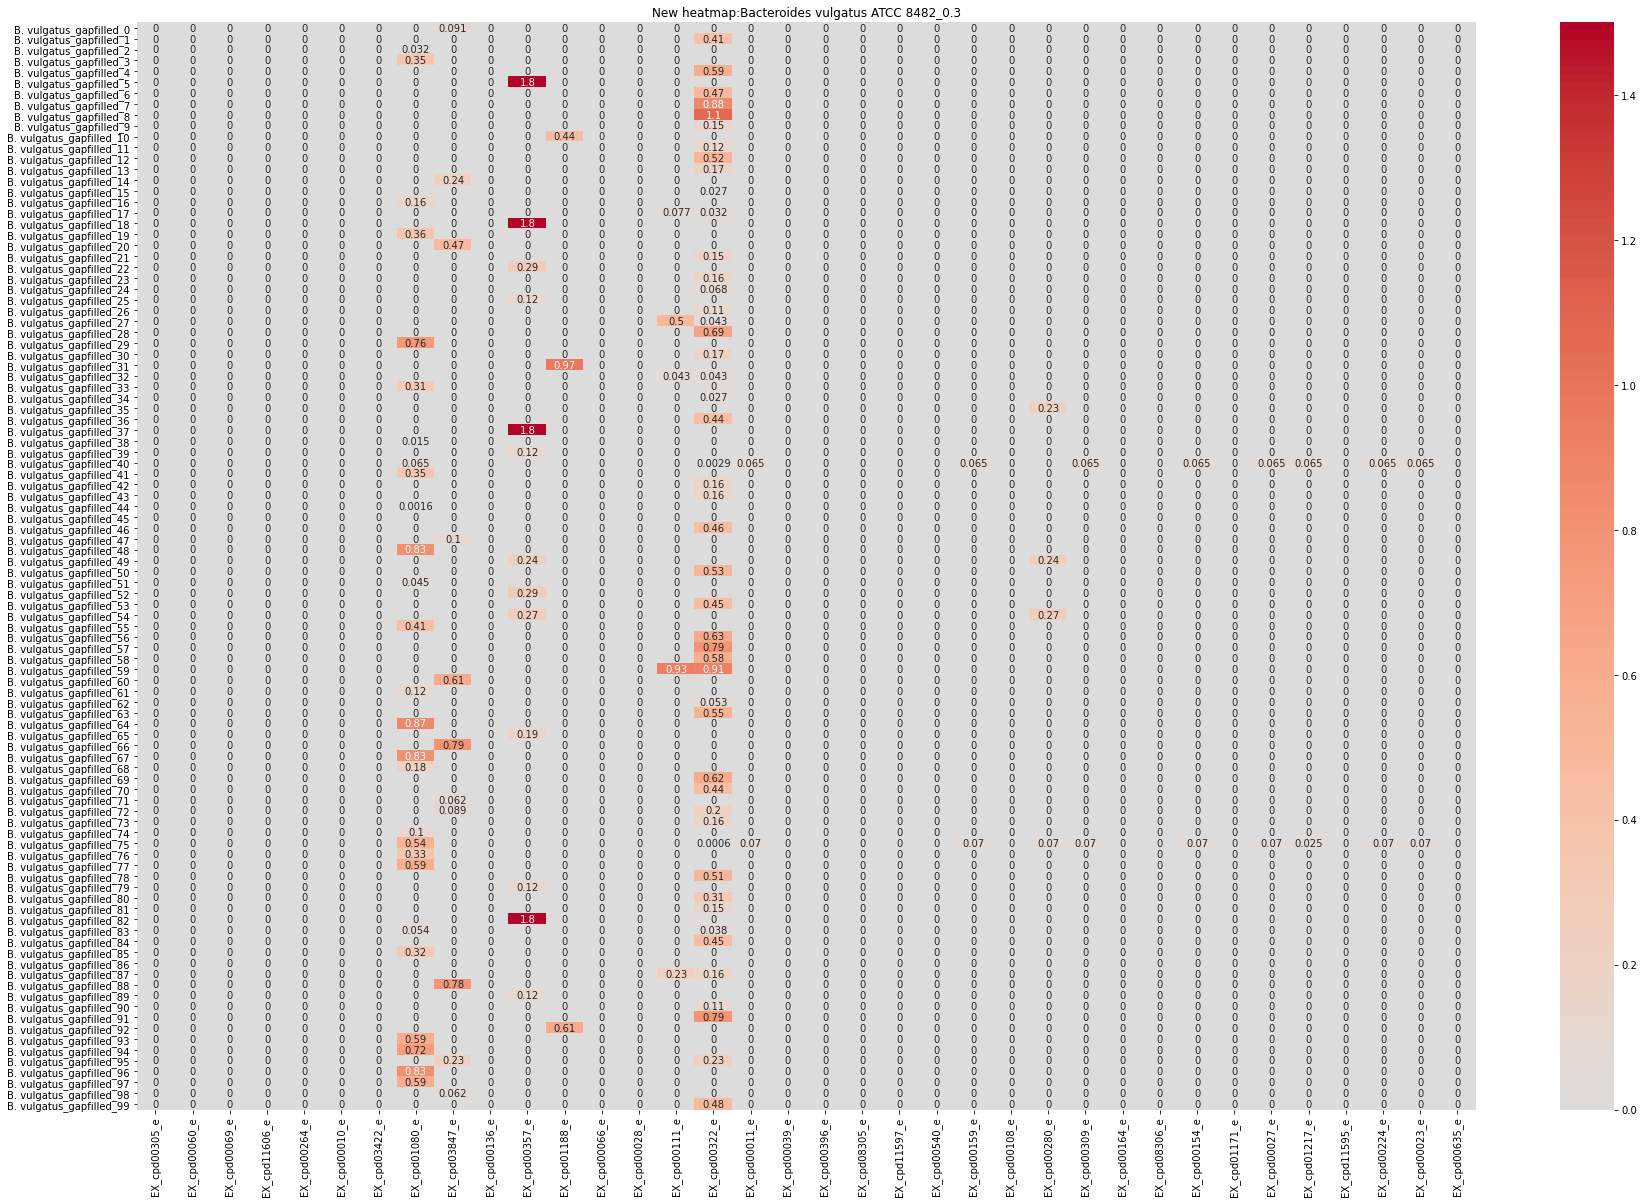

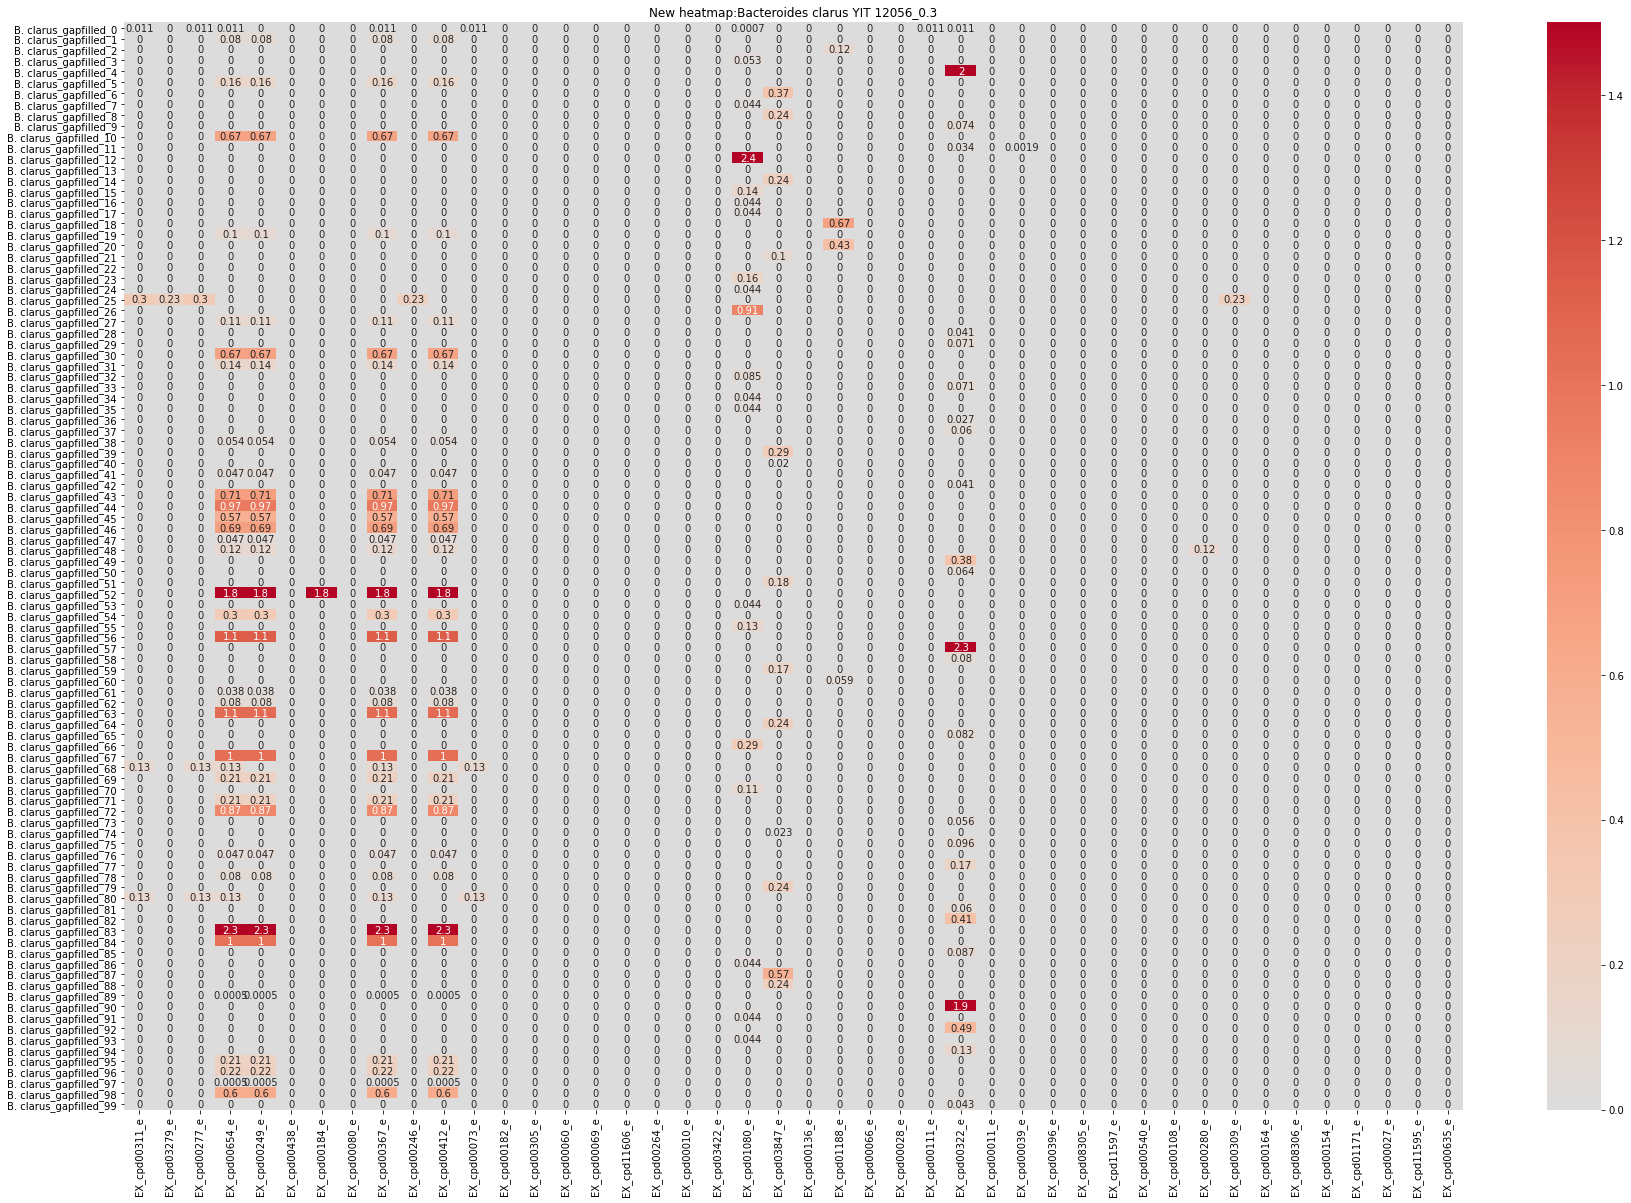

In [10]:
#!/usr/bin/env python
# coding: utf-8

# In[20]:
# %run ./module_code.ipynb

# Import packages

import pandas as pd
import json
import os
import numpy as np
import seaborn as sns
import medusa
from pickle import load
from termcolor import colored
import matplotlib.pyplot as plt
import pickle
from os.path import join 
import os.path
import itertools
import random
from itertools import chain
import os, json
from optlang.interface import OPTIMAL

from cobra.flux_analysis.gapfilling import GapFiller
from cobra.flux_analysis.parsimonious import add_pfba
from cobra.core import DictList

from cobra.util.solver import linear_reaction_coefficients

from medusa.core.ensemble import Ensemble
from medusa.core.feature import Feature
from medusa.core.member import Member
# from probanno import probanno
REACTION_ATTRIBUTES = ['lower_bound', 'upper_bound']
MISSING_ATTRIBUTE_DEFAULT = {'lower_bound':0,'upper_bound':0}


# ### Medium generating 

# In[2]:


metabolite_data_dict = {}
base_medium_dict = {}
base_medium_list = []
path_to_pickle = "/Users/basazinbelhu/probannopy/iterative_pfba/data/medusa_gapfilled_model_pickle/Trial/"
pkl_files = [pos_pkl for pos_pkl in os.listdir(path_to_pickle) if pos_pkl.endswith('.pkl')]
for filename in pkl_files:
    print(filename)
    with open(path_to_pickle+filename, 'rb') as infile:
        ensemble = pickle.load(infile)
#         print(ensemble)
    rxn_id = [m.id for m in ensemble.base_model.metabolites]
    metabolite = [m.name for m in ensemble.base_model.metabolites]
    metabolite_formula = [m.formula for m in ensemble.base_model.metabolites]
    metabolite_data = pd.DataFrame(
    {'rxn_id': [m.id for m in ensemble.base_model.metabolites],
     'formula': [m.formula for m in ensemble.base_model.metabolites],
     'name': [m.name for m in ensemble.base_model.metabolites] })
    for index, row in metabolite_data.iterrows():
        if "C" not in row['formula'] or (row['formula'][0]== "C" and row['formula'][1].islower()):
            metabolite_data.drop(index, inplace=True)
    for r in [i for i in metabolite_data["rxn_id"]]:
        base_medium_list.append("EX_"+r)
    metabolite_data_dict[os.path.splitext(filename)[0]]=  metabolite_data
    base_medium_dict[os.path.splitext(filename)[0]] = base_medium_list
    save_dir = ("/Users/basazinbelhu/probannopy/iterative_pfba/data/" +str(os.path.splitext(filename)[0])+".csv")
    a_file = open("base_medium_data.pkl", "wb")
    pickle.dump(base_medium_dict, a_file)
    a_file.close()



metabolite_data_dict = {}
base_medium_dict = {}
general_medium = []
base_medium_list = []
def hitmap(path_to_pickle):
    """
    This function takes the file path for the picke file. It iterating through the pickle file 
    and generate a heat map plot for each pickle file.
    """
    pkl_files = [pos_pkl for pos_pkl in os.listdir(path_to_pickle) if pos_pkl.endswith('.pkl')]
    for filename in pkl_files:
        import warnings
        warnings.filterwarnings('ignore')
        print(filename)
        with open(path_to_pickle+filename, 'rb') as infile:
            ensemble = pickle.load(infile)
        rxn_id = [m.id for m in ensemble.base_model.metabolites]
        metabolite = [m.name for m in ensemble.base_model.metabolites]
        metabolite_formula = [m.formula for m in ensemble.base_model.metabolites]
        metabolite_data = pd.DataFrame(
        {'rxn_id': [m.id for m in ensemble.base_model.metabolites],
         'formula': [m.formula for m in ensemble.base_model.metabolites],
         'name': [m.name for m in ensemble.base_model.metabolites] })
        for index, row in metabolite_data.iterrows():
            if "C" not in row['formula'] or (row['formula'][0]== "C" and row['formula'][1].islower()):
                metabolite_data.drop(index, inplace=True)
        for r in [i for i in metabolite_data["rxn_id"]]:
            general_medium.append("EX_"+r)
        print(len(general_medium))
        for x in general_medium:
            # check if exists in unique_list or not
            if x not in base_medium_list:
                if x.endswith("_e"):
                    base_medium_list.append(x)
        metabolite_data_dict[os.path.splitext(filename)[0]]=  metabolite_data
        base_medium_dict[os.path.splitext(filename)[0]] = base_medium_list
    #     print(base_medium_list)

        ensemble_dict = {}
        for member in ensemble.members:
            cobra_model = ensemble.extract_member(member)
            max_growth = cobra_model.slim_optimize()
            # Assigning new flux to all metabolites 
            ensemble_dict[member.id] = []
            #  carbon_source_value = []
            medium = cobra_model.medium
            for i in medium.keys():
        #         if i in base_medium_list:
                medium[i] = 0.0167      
            cobra_model.medium  = medium  
            true_carbone_source = []
            carbon_source_dict = {}
            carbon_source_value = []
            flux = {}
            # Iterating throught the carbone soure candidates
            for m in base_medium_list:
                if m.endswith("_e"):
                    with cobra_model:
                            #update the flux 

                        # Assign a high flux for one carbone sources at a time 
                        #if that carbob source in the medium
                        if m in medium.keys(): 
                            carbon_source_dict[m] = []
                            true_carbone_source.append(m)
                            medium[m] = 100
                            true_carbone_source.append(m)
        #                     print(cobra_model.medium)
                            cobra_model.medium  = medium
                            new_objective_value = cobra_model.optimize().objective_value
                            carbon_source_value.append(new_objective_value)
                            carbon_source_dict[m] = new_objective_value
                            medium[m] = 0.0167
            ensemble_dict[member.id]= carbon_source_dict
            raw_data = pd.DataFrame.from_dict(ensemble_dict,orient='index')
            data = raw_data.sub(raw_data.min(axis=1), axis=0)
            data= data.round(4)
            col = [f for f in data.columns]
            col.reverse()
            data = data[col]
#         print(data.head(5))
        fig = plt.figure(figsize = (30,20))
        rt = sns.heatmap(data, center=0, cmap= "coolwarm",vmin=0, vmax= 1.5, annot = True)   
        rt.set_title("New heatmap:"+str(os.path.splitext(filename)[0]))
        plt.savefig(str(os.path.splitext(filename)[0])+".png")
    return(rt)



hitmap(path_to_pickle)